# Mesh Discretization Comparison — Lunar P and PcP Sensitivity Kernels

This notebook compares P-wave travel-time sensitivity kernels computed on two
different radial mesh discretizations of the `weber_core` lunar velocity model:

| Mesh   | Shell thickness | Shells |
|--------|----------------|--------|
| Coarse | dr = 100 km    | ~18    |
| Fine   | dr = 10 km     | ~174   |

The coarser mesh averages velocity over large shells and produces blocky, staircase
kernels, whereas the finer mesh resolves rapid velocity variations near discontinuities
and produces smoother profiles.  Comparing the two reveals how discretization
affects resolution of the sensitivity distribution.

**Workflow**
1. Load the `weber_core` model.
2. Build a coarse (dr = 100 km) and a fine (dr = 10 km) spherical mesh.
3. Define 3 Apollo-like stations and 3 synthetic events.
4. Compute P and PcP ray paths with TauPy.
5. Compute kernels on both meshes.
6. Compare kernels per phase in overlaid step-line plots.
7. Compare stacked (summed) kernels per phase and discretization.

## 1 · Import required libraries

In [15]:
import sys, os
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), ''))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sensray import PlanetModel

print("SensRay imported OK")
print(f"Available standard models: {PlanetModel.list_standard_models()}")

SensRay imported OK
Available standard models: ['1066a', '1066b', 'M1', 'M2', 'M2_resampled_on_M1', 'M3', 'M3_resampled_on_M1', 'ak135favg', 'ak135fcont', 'ak135fsyngine', 'alfs', 'herrin', 'jb', 'prem', 'pwdk', 'weber_core', 'weber_core_resampled_on_M1', 'weber_core_smooth', 'weber_core_smooth_resampled_on_M1']


## 2 · Load the lunar velocity model

We use `weber_core` — a 1-D lunar model with mantle, outer-core, and inner-core,
enabling PcP reflections off the core–mantle boundary (CMB at ~1408 km depth).

In [16]:
model = PlanetModel.from_standard_model('weber_core')

LUNAR_R = model.radius
CORE_R  = LUNAR_R - 1408.0   # CMB radius (km)

print(f"Model  : {model.name}")
print(f"Radius : {LUNAR_R:.2f} km   CMB at radius {CORE_R:.1f} km")
print()
print("Layer structure:")
for name, data in model.layers.items():
    d_min = float(min(data['depth']))
    d_max = float(max(data['depth']))
    vp_min = float(min(data['vp']))
    vp_max = float(max(data['vp']))
    print(f"  {name:20s}  depth {d_min:7.1f}–{d_max:7.1f} km   "
          f"vp {vp_min:.2f}–{vp_max:.2f} km/s")

Model  : WEBER_CORE
Radius : 1738.00 km   CMB at radius 330.0 km

Layer structure:
  surface               depth     0.0–   38.0 km   vp 1.00–5.50 km/s
  mantle                depth    38.0– 1408.0 km   vp 7.40–8.15 km/s
  outer-core            depth  1408.0– 1498.0 km   vp 4.10–4.10 km/s
  inner-core            depth  1498.0– 1738.0 km   vp 4.30–4.30 km/s


## 3 · Build two spherical meshes

We create two independent 1-D spherical meshes from the same `weber_core` model:

* **Coarse** — `dr = 100 km`, ~18 shells: representative of typical lunar inversion parametrizations.
* **Fine** — `dr = 10 km`, ~174 shells: resolves finer structure near discontinuities and turning depths.

Both meshes are populated with `vp`, `vs`, and `rho` using volume-weighted radial integration.

Generated spherical mesh: 18 layers, 19 boundaries
Populated properties: ['vp', 'vs', 'rho']
Coarse  dr=  100 km  →    18 shells
Generated spherical mesh: 174 layers, 175 boundaries
Populated properties: ['vp', 'vs', 'rho']
Fine    dr=   10 km  →   174 shells


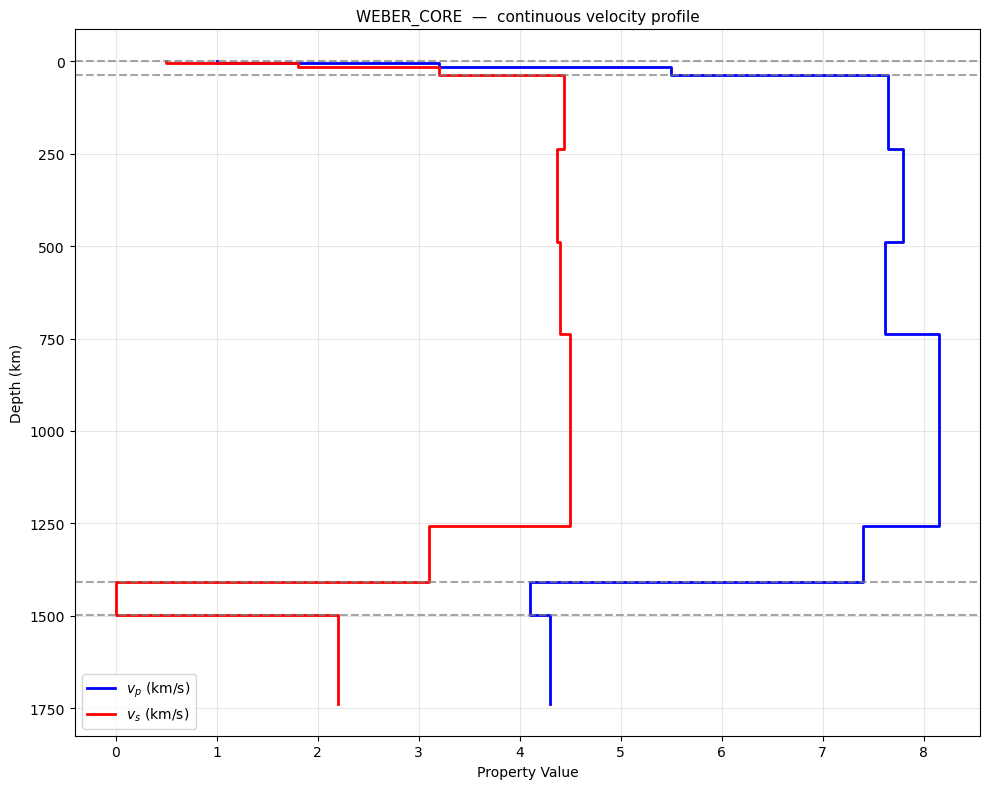

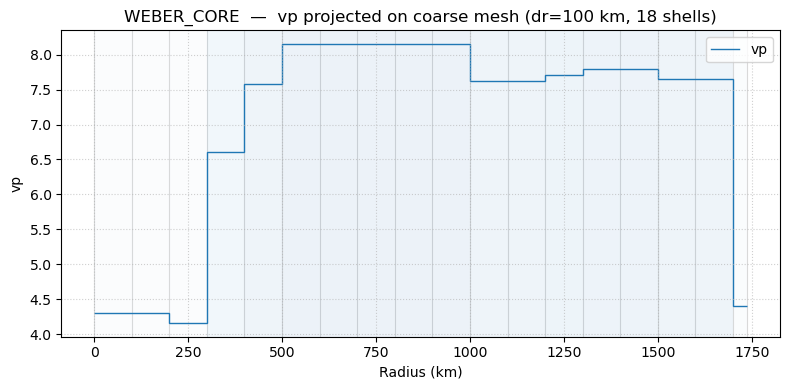

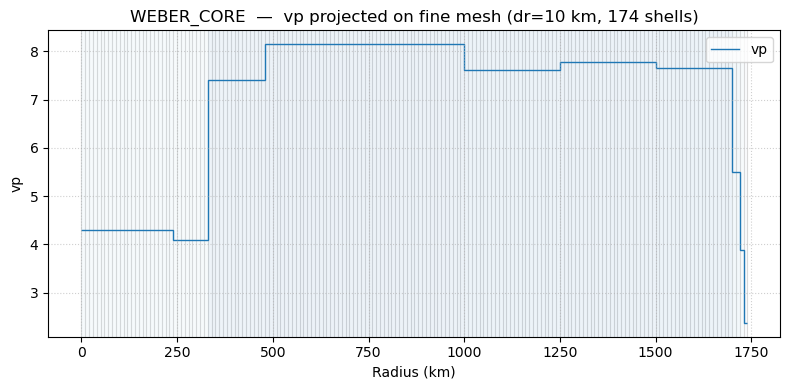

In [17]:
def build_mesh(model, dr):
    """Build a uniform spherical mesh with shell thickness dr (km)."""
    radii = list(np.arange(0.0, model.radius, dr))
    if radii[-1] < model.radius:
        radii.append(model.radius)
    m = model.create_mesh('spherical', radii=radii)
    m.populate_properties(['vp', 'vs', 'rho'])
    return m, np.array(radii)

# ── Coarse mesh: dr = 100 km ──────────────────────────────────────────────────
DR_COARSE = 100.0
mesh_coarse, r_bnd_coarse = build_mesh(model, DR_COARSE)
print(f"Coarse  dr={DR_COARSE:5.0f} km  →  {mesh_coarse.mesh.n_cells:4d} shells")

# ── Fine mesh: dr = 10 km ─────────────────────────────────────────────────────
DR_FINE = 10.0
mesh_fine, r_bnd_fine = build_mesh(model, DR_FINE)
print(f"Fine    dr={DR_FINE:5.0f} km  →  {mesh_fine.mesh.n_cells:4d} shells")

# ── Plot profiles using built-in methods ──────────────────────────────────────
fig, ax = model.plot_profiles(properties=['vp', 'vs'], show_discontinuities=True)
ax.set_title(f'{model.name}  —  continuous velocity profile', fontsize=11)
plt.tight_layout(); plt.show()

fig, ax = mesh_coarse.plot_shell_property(
    'vp', show_plot=False,
    title=f'{model.name}  —  vp projected on coarse mesh (dr={DR_COARSE:.0f} km, {mesh_coarse.mesh.n_cells} shells)')
plt.tight_layout(); plt.show()

fig, ax = mesh_fine.plot_shell_property(
    'vp', show_plot=False,
    title=f'{model.name}  —  vp projected on fine mesh (dr={DR_FINE:.0f} km, {mesh_fine.mesh.n_cells} shells)')
plt.tight_layout(); plt.show()


## 4 · Define stations and events

Same geometry as notebook 05: three Apollo ALSEP stations and three synthetic
shallow events giving epicentral distances in the 30°–120° range.

In [18]:
stations = {
    'S12': {'lat':   3.04, 'lon': -23.42},
    'S14': {'lat':  -3.64, 'lon': -17.48},
    'S15': {'lat':  26.13, 'lon':   3.63},
}
events = {
    'E1': {'lat':  20.0, 'lon':  130.0, 'depth_km': 5.0},
    'E2': {'lat': -40.0, 'lon':  -60.0, 'depth_km': 5.0},
    'E3': {'lat':   5.0, 'lon':  -90.0, 'depth_km': 5.0},
}

def gc_distance(lat1, lon1, lat2, lon2):
    φ1, λ1 = np.radians(lat1), np.radians(lon1)
    φ2, λ2 = np.radians(lat2), np.radians(lon2)
    Δλ = λ2 - λ1
    a = np.sqrt((np.cos(φ2)*np.sin(Δλ))**2 +
                (np.cos(φ1)*np.sin(φ2) - np.sin(φ1)*np.cos(φ2)*np.cos(Δλ))**2)
    b = np.sin(φ1)*np.sin(φ2) + np.cos(φ1)*np.cos(φ2)*np.cos(Δλ)
    return np.degrees(np.arctan2(a, b))

print(f"{'Station':>6}  {'Event':>4}  {'Δ (°)':>7}")
print("-" * 24)
for sname, sta in stations.items():
    for ename, evt in events.items():
        dist = gc_distance(sta['lat'], sta['lon'], evt['lat'], evt['lon'])
        print(f"{sname:>6}  {ename:>4}  {dist:7.2f}")

Station  Event    Δ (°)
------------------------
   S12    E1   145.19
   S12    E2    54.54
   S12    E3    66.42
   S14    E1   144.34
   S14    E2    52.82
   S14    E3    72.96
   S15    E1   110.47
   S15    E2    88.72
   S15    E3    91.05


## 5 · Compute ray paths via TauPy

In [19]:
print("Building TauPy model (cached after first call)…")
taup = model.taupy_model
print("Ready.\n")

rays_catalog = {}

for sname, sta in stations.items():
    for ename, evt in events.items():
        dist_deg = gc_distance(sta['lat'], sta['lon'], evt['lat'], evt['lon'])
        arrivals = taup.get_ray_paths(
            source_depth_in_km=evt['depth_km'],
            distance_in_degree=dist_deg,
            phase_list=['P', 'PcP'],
        )
        found = {}
        for arr in arrivals:
            ph = arr.phase.name
            if ph not in found:
                found[ph] = arr
        for ph, arr in found.items():
            rays_catalog[(sname, ename, ph)] = arr
            print(f"  {sname}–{ename}  {ph:4s}  Δ={dist_deg:6.2f}°  t={arr.time:.1f} s")

print(f"\nTotal rays: {len(rays_catalog)}")

Building TauPy model (cached after first call)…
Building obspy.taup model for '/home/adrian/PhD/masters/SensRay/sensray/models/weber_core.nd' ...
filename = /home/adrian/PhD/masters/SensRay/sensray/models/weber_core.nd
Done reading velocity model.
Radius of model . is 1738.0
Using parameters provided in TauP_config.ini (or defaults if not) to call SlownessModel...
Parameters are:
taup.create.min_delta_p = 0.1 sec / radian
taup.create.max_delta_p = 11.0 sec / radian
taup.create.max_depth_interval = 115.0 kilometers
taup.create.max_range_interval = 0.04363323129985824 degrees
taup.create.max_interp_error = 0.05 seconds
taup.create.allow_inner_core_s = True
Slow model  701 P layers,898 S layers
Done calculating Tau branches.
Done Saving /tmp/weber_core.npz
Method run is done, but not necessarily successful.
Ready.

  S12–E1  P     Δ=145.19°  t=427.2 s
  S12–E1  PcP   Δ=145.19°  t=436.9 s
  S12–E2  P     Δ= 54.54°  t=218.7 s
  S12–E2  PcP   Δ= 54.54°  t=380.0 s
  S12–E3  P     Δ= 66.42°  t

## 6 · Compute sensitivity kernels on both meshes

For each ray in `rays_catalog` we call `mesh.compute_sensitivity_kernel(arr, 'vp')`
on both the coarse and the fine mesh, and store the resulting 1-D arrays.

In [20]:
kernels_coarse = {}
kernels_fine   = {}

for key, arr in rays_catalog.items():
    sname, ename, phase = key
    tag = f"{sname}_{ename}_{phase}"

    k_c = mesh_coarse.compute_sensitivity_kernel(arr, 'vp', attach_name=f'K_coarse_{tag}')
    k_f = mesh_fine.compute_sensitivity_kernel(  arr, 'vp', attach_name=f'K_fine_{tag}')

    kernels_coarse[key] = k_c
    kernels_fine[key]   = k_f

    print(f"  {sname}–{ename} {phase:4s}  "
          f"coarse max|K|={np.abs(k_c).max():.3e}   "
          f"fine max|K|={np.abs(k_f).max():.3e} s/km")

print(f"\nDone. {len(kernels_coarse)} × 2 kernels computed.")

Stored sensitivity kernel as cell data: 'K_coarse_S12_E1_P'
Stored sensitivity kernel as cell data: 'K_fine_S12_E1_P'
  S12–E1 P     coarse max|K|=7.414e+00   fine max|K|=2.650e+00 s/km
Stored sensitivity kernel as cell data: 'K_coarse_S12_E1_PcP'
Stored sensitivity kernel as cell data: 'K_fine_S12_E1_PcP'
  S12–E1 PcP   coarse max|K|=7.982e+00   fine max|K|=1.959e+00 s/km
Stored sensitivity kernel as cell data: 'K_coarse_S12_E2_P'
Stored sensitivity kernel as cell data: 'K_fine_S12_E2_P'
  S12–E2 P     coarse max|K|=1.009e+01   fine max|K|=3.821e+00 s/km
Stored sensitivity kernel as cell data: 'K_coarse_S12_E2_PcP'
Stored sensitivity kernel as cell data: 'K_fine_S12_E2_PcP'
  S12–E2 PcP   coarse max|K|=3.790e+00   fine max|K|=1.955e+00 s/km
Stored sensitivity kernel as cell data: 'K_coarse_S12_E3_P'
Stored sensitivity kernel as cell data: 'K_fine_S12_E3_P'
  S12–E3 P     coarse max|K|=1.652e+01   fine max|K|=4.375e+00 s/km
Stored sensitivity kernel as cell data: 'K_coarse_S12_E3_PcP'


## 7 · Overlaid ray kernels per phase — coarse vs fine

A 2 × 2 grid of step-line plots:
- **Rows**: P (top) and PcP (bottom)
- **Columns**: coarse dr = 100 km (left) and fine dr = 10 km (right)

SensRay natively returns $\tilde{K}_j = -L_j/v_j^2$, the forward operator row entries
(units s km⁻¹). These are proportional to shell volume $V_j$ and cannot be compared
across different discretisations.

To compare fairly, the plotted quantity is the **kernel expansion coefficient**:

$$K_j^\text{coeff} = M_{jj}^{-1}\,\tilde{K}_j = \frac{\tilde{K}_j}{V_j}
= \frac{-L_j}{v_j^2 \cdot \tfrac{4\pi}{3}(r_{j+1}^3 - r_j^3)}$$

where the diagonal 3D mass matrix entry $M_{jj} = V_j = \tfrac{4\pi}{3}(r_{j+1}^3-r_j^3)$
is the shell volume.  $K_j^\text{coeff}$ is the $L^2(dV)$-projection of the continuous
sensitivity kernel onto the pixel basis, is resolution-independent, and converges to
the continuous kernel $K(r) = -v^{-2}\,dL/dV$ as $\Delta r \to 0$.
Units: s km⁻⁴.


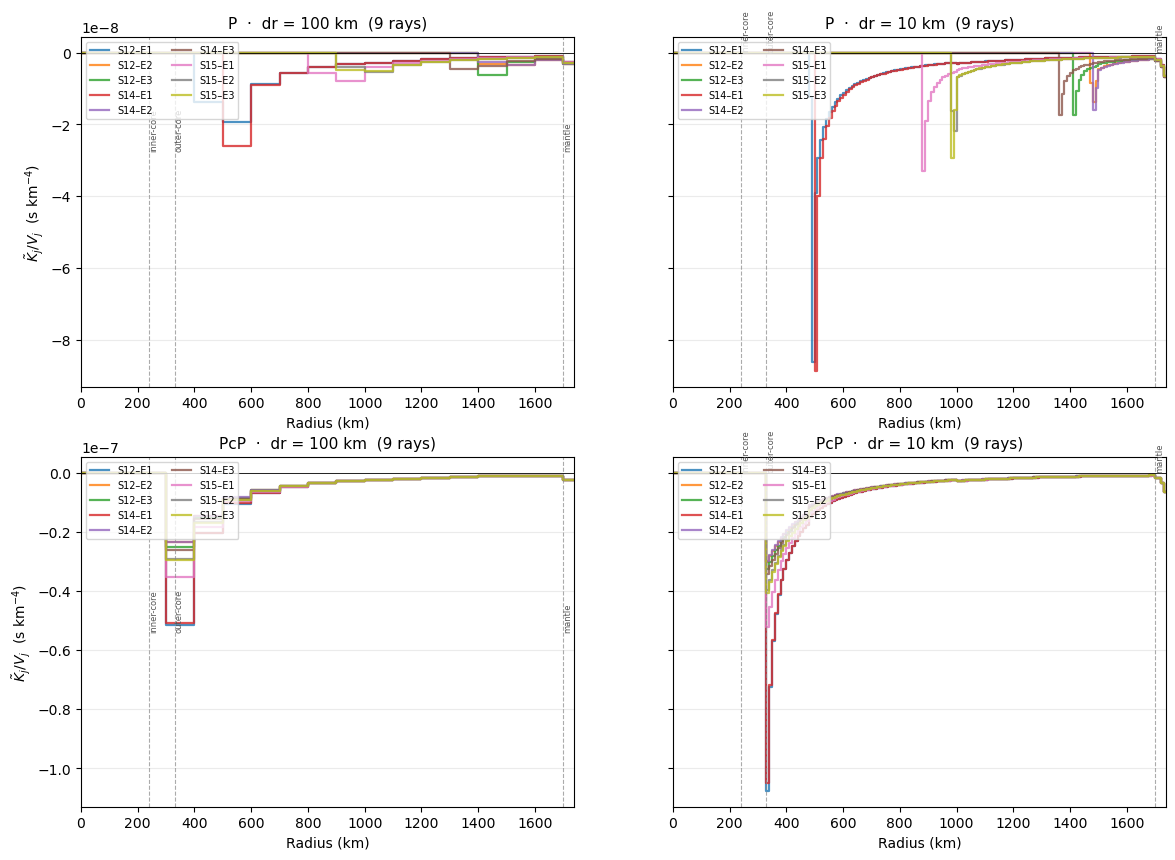

In [24]:
phases_to_plot = ['P', 'PcP']
mesh_configs = [
    (mesh_coarse, r_bnd_coarse, kernels_coarse, f'dr = {DR_COARSE:.0f} km'),
    (mesh_fine,   r_bnd_fine,   kernels_fine,   f'dr = {DR_FINE:.0f} km'),
]

disc_radii = {name: LUNAR_R - info['depth']
              for name, info in model.get_discontinuities(outwards=False).items()}

fig, axes = plt.subplots(len(phases_to_plot), len(mesh_configs),
                         figsize=(14, 10), sharey='row')

for row, phase in enumerate(phases_to_plot):
    for col, (mesh_obj, r_bnd, kernels, label) in enumerate(mesh_configs):
        ax = axes[row][col]
        phase_keys = [k for k in kernels if k[2] == phase]
        palette    = sns.color_palette('tab10', n_colors=len(phase_keys))
        # Shell volumes V_j = (4π/3)(r_{j+1}^3 - r_j^3)  [km³]
        vol = (4 * np.pi / 3) * (r_bnd[1:]**3 - r_bnd[:-1]**3)

        for color, key in zip(palette, phase_keys):
            sname, ename, _ = key
            # Kernel expansion coefficient K_j^coeff = K̃_j / V_j  (s km⁻⁴)
            # Resolution-independent L²(dV) projection; converges to K(r) as Δr→0
            kdens = kernels[key] / vol

            r_plot, k_plot = [], []
            for i in range(len(kdens)):
                r_plot.extend([r_bnd[i], r_bnd[i+1]])
                k_plot.extend([kdens[i], kdens[i]])

            ax.plot(r_plot, k_plot, color=color, lw=1.6, alpha=0.8,
                    label=f'{sname}–{ename}')

        # Discontinuity verticals
        for disc_name, r_disc in disc_radii.items():
            if 0 < r_disc < LUNAR_R:
                ax.axvline(r_disc, color='#888888', lw=0.8, ls='--', alpha=0.7)
                ax.text(r_disc, ax.get_ylim()[0] if col == 0 else 0,
                        disc_name, fontsize=6, color='#555555',
                        va='bottom', ha='left', rotation=90)

        ax.axhline(0, color='black', lw=0.6)
        ax.set_xlim(0, LUNAR_R)
        ax.set_xlabel('Radius (km)', fontsize=10)
        if col == 0:
            ax.set_ylabel(r'$\tilde{K}_j / V_j$  (s km$^{-4}$)', fontsize=10)
        ax.set_title(f'{phase}  ·  {label}  ({len(phase_keys)} rays)', fontsize=11)
        ax.legend(fontsize=7, loc='upper left', framealpha=0.8, ncol=2)
        ax.grid(True, axis='y', alpha=0.25)


## 8 · Stacked kernel density — phase totals

Each column sums all ray contributions for a given phase and discretisation.
The plotted quantity is again the expansion coefficient

$$\Sigma_j = \sum_\text{rays} K_j^\text{coeff} = \frac{\tilde{K}_j}{V_j}
= \frac{-L_j}{v_j^2 \cdot \tfrac{4\pi}{3}(r_{j+1}^3 - r_j^3)}$$

Because $V_j$ correctly accounts for the $r^2$ Jacobian of spherical shells, any
remaining differences in amplitude between the coarse and fine
columns are genuine resolution effects: the coarse mesh blurs sharp features by
averaging over wide shells (e.g. the CMB jump in PcP), while the fine mesh resolves them.


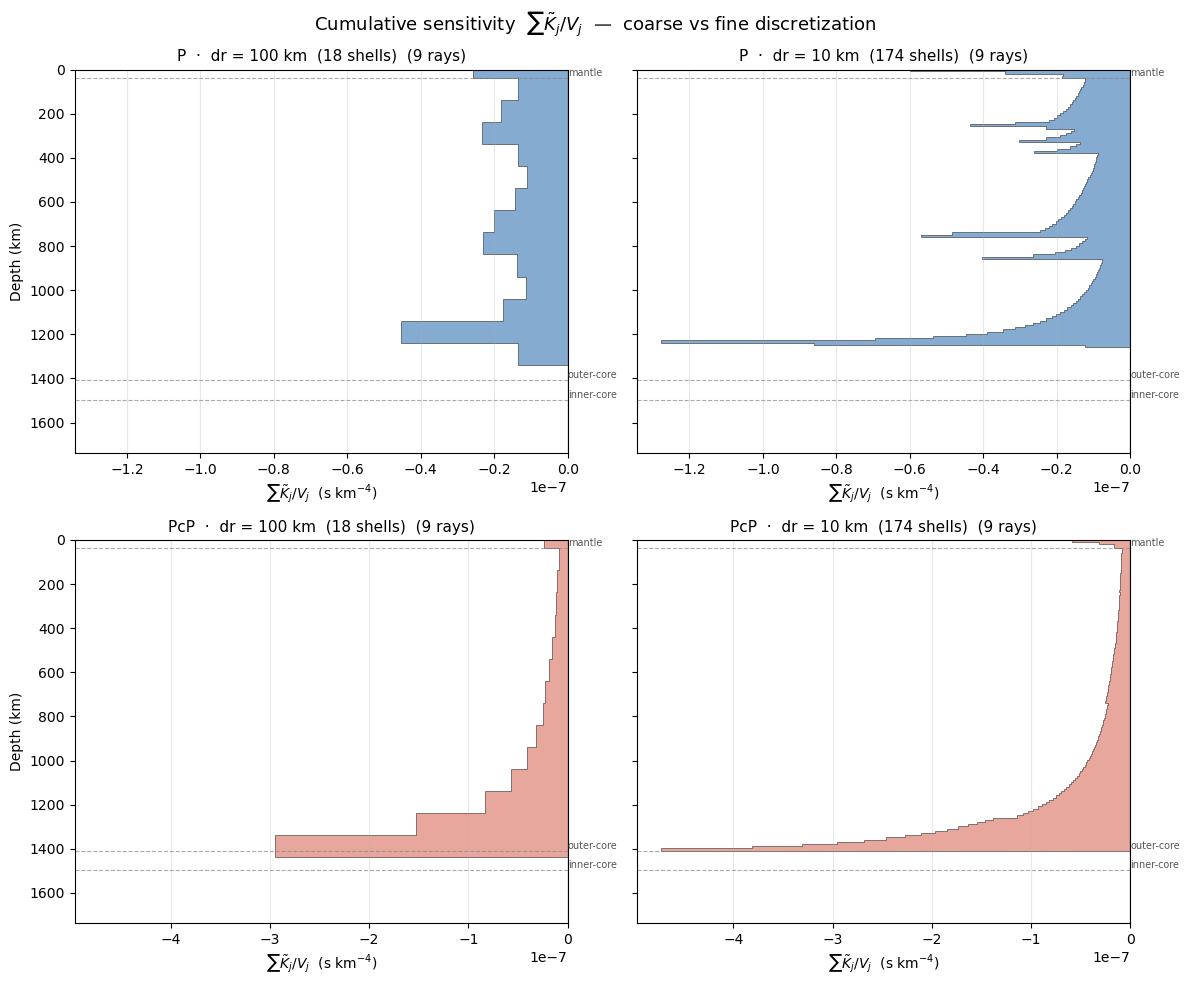

In [25]:
phase_colors = {'P': '#2166ac', 'PcP': '#d6604d'}

disc_depths = {name: info['depth']
               for name, info in model.get_discontinuities(outwards=False).items()}

# ── Build per-phase summed kernel expansion coefficient for both meshes ────────
# K_j^coeff = K̃_j / V_j  (s km⁻⁴) — L²(dV) projection, resolution-independent
def phase_sum_densities(kernels_dict, r_bnd):
    vol = (4 * np.pi / 3) * (r_bnd[1:]**3 - r_bnd[:-1]**3)  # [km³]
    sums = defaultdict(lambda: np.zeros(len(vol)))
    for (sn, en, ph), k in kernels_dict.items():
        sums[ph] += k / vol
    return sums

sum_coarse = phase_sum_densities(kernels_coarse, r_bnd_coarse)
sum_fine   = phase_sum_densities(kernels_fine,   r_bnd_fine)

phases_available = sorted(sum_coarse.keys())

configs = [
    (sum_coarse, r_bnd_coarse, f'dr = {DR_COARSE:.0f} km  ({mesh_coarse.mesh.n_cells} shells)'),
    (sum_fine,   r_bnd_fine,   f'dr = {DR_FINE:.0f} km  ({mesh_fine.mesh.n_cells} shells)'),
]

fig, axes = plt.subplots(len(phases_available), 2,
                         figsize=(12, 5 * len(phases_available)),
                         sharey='row', sharex='row')   # share x per row → fair amplitude comparison

for row, phase in enumerate(phases_available):
    color = phase_colors.get(phase, 'steelblue')
    for col, (sums, r_bnd, cfg_label) in enumerate(configs):
        ax = axes[row][col]
        K_dens = sums[phase]                   # Σ K̃_j / V_j  (s km⁻⁴)
        depths_bnd = LUNAR_R - r_bnd           # radius boundaries → depth boundaries

        ax.stairs(K_dens, depths_bnd,
                  orientation='horizontal',
                  baseline=0, fill=True, alpha=0.55,
                  color=color, edgecolor='k', linewidth=0.6)
        ax.axvline(0, color='k', lw=0.8)

        for disc_name, d in disc_depths.items():
            if 0 < d < LUNAR_R:
                ax.axhline(d, color='#888888', lw=0.8, ls='--', alpha=0.7)
                ax.text(0, d, disc_name, fontsize=7, color='#555555', va='bottom')

        ax.set_ylim(LUNAR_R, 0)
        ax.set_xlabel(r'$\sum \tilde{K}_j / V_j$  (s km$^{-4}$)', fontsize=10)
        if col == 0:
            ax.set_ylabel('Depth (km)', fontsize=10)
        n_rays = sum(1 for k in kernels_coarse if k[2] == phase)
        ax.set_title(f'{phase}  ·  {cfg_label}  ({n_rays} rays)', fontsize=11)
        ax.grid(True, axis='x', alpha=0.3)

fig.suptitle(r'Cumulative sensitivity  $\sum \tilde{K}_j/V_j$  —  coarse vs fine discretization',
             fontsize=13)
plt.tight_layout()
plt.show()


In [23]:

import numpy as np

# ── 1. Check whether the live Python kernel has the fix or the bug ─────────
import sensray.planet_model as _pm
import inspect
src = inspect.getsource(_pm.PlanetModel.get_property_at_radius)
has_fix = 'using_depths=False' not in src
print(f"get_property_at_radius has fix applied : {has_fix}")
print()

# ── 2. Check what vp is stored on both meshes (inner-core sanity check) ───
# Inner core r < 240 km → correct vp = 4.30 km/s (flat)
# With the bug, it should show an affine ramp instead
fine_radii   = np.array(mesh_fine.mesh.radii)
fine_vp      = np.array(mesh_fine.mesh.cell_data['vp'])
fine_centers = 0.5 * (fine_radii[:-1] + fine_radii[1:])

coarse_radii   = np.array(mesh_coarse.mesh.radii)
coarse_vp      = np.array(mesh_coarse.mesh.cell_data['vp'])
coarse_centers = 0.5 * (coarse_radii[:-1] + coarse_radii[1:])

ic_mask_f = fine_centers < 240.0
ic_mask_c = coarse_centers < 240.0

print("Inner-core shells (r < 240 km) — expected flat vp = 4.30 km/s")
print(f"  Coarse : {coarse_vp[ic_mask_c].round(4)}")
print(f"  Fine   : {fine_vp[ic_mask_f].round(4)}")
print()

# ── 3. Kernel scaling — what is actually conserved? ───────────────────────
key = ('S12', 'E1', 'P')
k_c = kernels_coarse[key]
k_f = kernels_fine[key]
dr_c = np.diff(np.array(mesh_coarse.mesh.radii))
dr_f = np.diff(np.array(mesh_fine.mesh.radii))

print("=== What is actually conserved? ===")
print(f"  Σ K_j       coarse = {k_c.sum():.4f}   fine = {k_f.sum():.4f}   "
      f"  <- K_j is INTEGRATED (path length per shell), plain sum conserved")
print(f"  Σ K_j·dr_j  coarse = {np.dot(k_c, dr_c):.4f}   fine = {np.dot(k_f, dr_f):.4f}"
      f"  <- NOT conserved (would be if K_j were a density)")
print()
print("Conclusion: K_j = –L_j/v_j²  is an INTEGRAL over the shell (km of path ÷ v²).")
print("  Individual K_j values ∝ dr  →  finer mesh → smaller per-cell K_j.  This is correct.")
print("  To compare shapes across discretisations, plot K_j/dr_j (sensitivity density).")


get_property_at_radius has fix applied : True

Inner-core shells (r < 240 km) — expected flat vp = 4.30 km/s
  Coarse : [4.3 4.3]
  Fine   : [4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3 4.3
 4.3 4.3 4.3 4.3 4.3 4.3]

=== What is actually conserved? ===
  Σ K_j       coarse = -55.7827   fine = -56.2460     <- K_j is INTEGRATED (path length per shell), plain sum conserved
  Σ K_j·dr_j  coarse = -5347.9086   fine = -558.5339  <- NOT conserved (would be if K_j were a density)

Conclusion: K_j = –L_j/v_j²  is an INTEGRAL over the shell (km of path ÷ v²).
  Individual K_j values ∝ dr  →  finer mesh → smaller per-cell K_j.  This is correct.
  To compare shapes across discretisations, plot K_j/dr_j (sensitivity density).
